In [1]:
import pandas as pd
import numpy as np
import random 
import datetime
import timeit
import matplotlib.pyplot as plt

In [2]:
#Part 1
#Reading files and creating required dataframes
xls = pd.ExcelFile(r"C:\Users\Devadath\Desktop\Gorilla Test\data.xlsx")
fc = pd.read_excel(xls, 'Forecasted Consumption', index_col='Meter ID')
ml = pd.read_excel(xls, 'Meter List', index_col = 'Meter ID')
rates = pd.read_excel(xls, 'Rates', index_col = 'Exit Zone')

#Setting upper bounds to infinity
rates = rates.fillna(np.inf)

tcpm = list()
tc = list()
mid = list()

for i,row in ml.iterrows(): #For every Meter ID
    ez = ml.loc[i,'Exit Zone'] #Identify the Exit Zone
    aq = ml.loc[i,'Annual Quantity (kWh)'] #Identify the Annual Quantity
    
    reqexrates = rates.loc[ez] #Find the rate ranges for that Exit Zone
    
    reqdaterange = reqexrates.loc[(reqexrates['Annual Quantity (Max)']>aq) & (reqexrates['Annual Quantity (Min)']<aq) ] #Find the applicable value from the range
    reqdaterange = reqdaterange.reset_index()
    fcreq = fc.loc[i] #Find the Consumption readings of the given Meter
    fcreq = fcreq.reset_index()
    
    pper = list()
    k=0
    for j,row in fcreq.iterrows(): #Price at a given date
        
        if (fcreq.loc[j,'Date']>=reqdaterange.loc[k,'Date']) & (fcreq.loc[j,'Date']<reqdaterange.loc[k+1,'Date']):
            pper.append(reqdaterange.loc[k,'Rate (p/kWh)'])
        else:
            k=k+1
            pper.append(reqdaterange.loc[k,'Rate (p/kWh)'])
            
    tcpm.append(sum(fcreq['kWh']*pper/100))
    tc.append(sum(fcreq['kWh']))
    mid.append(i)
    
tcpm = [round(num, 2) for num in tcpm] #Rounding up for 2 decimal spots
tc = [round(num, 2) for num in tc]

part1 = pd.DataFrame(list(zip(mid,tc,tcpm)), columns =['Meter ID', 'Total Estimated Consumption (kWh)','Total Cost (£)'])
part1 = part1.set_index("Meter ID")
print (part1)

            Total Estimated Consumption (kWh)  Total Cost (£)
Meter ID                                                     
1000000603                            24674.0            8.27
10588707                             122450.0           28.50
10626610                             303558.0           88.24


In [3]:
#Part 2
def part2(rates, num=random.randint(1,100)):  #Number of meters can be specified. If not, random between 1 and 100
    rates = rates.reset_index()
    ezunilist = set(rates['Exit Zone'])
    midlist = list(np.random.randint(low = 1,high=999999999,size=num)) #Random Meter numbers
    ezlocs = list(np.random.randint(low = 1,high=len(ezunilist),size=num)) #Random Zones  for the meters
    ezlist = [list(ezunilist)[i] for i in ezlocs]  
    aqlist = random.sample(range(1, 999999), num) #Random AQs
    part2 = pd.DataFrame(list(zip(midlist,ezlist,aqlist)), columns =['Meter ID', 'Exit Zone','Annual Quantity (kWh)'])
    return part2

In [4]:
#Part 3
def part3(midlist,sdate,smonth,syear,edate,emonth,eyear):
    stdate = datetime.date(syear,smonth,sdate)
    endate = datetime.date(eyear,emonth,edate)
    
    everyday = pd.date_range(stdate,endate,freq='d')
    part3 = pd.DataFrame(columns =['Date','Meter ID','kWh'])
    for i in midlist:
        mid = [i]*len(everyday)
        cons = list(np.random.randint(low = 1,high=999,size=len(everyday)))
        temp = pd.DataFrame(list(zip(everyday,mid,cons)), columns =['Date','Meter ID','kWh'])
        part3 = pd.concat([part3,temp])
        part3.sort_values(by=['Date'], inplace=True)
    return part3

Text(0.5, 1.0, 'Benchmarking wrt number of meters')

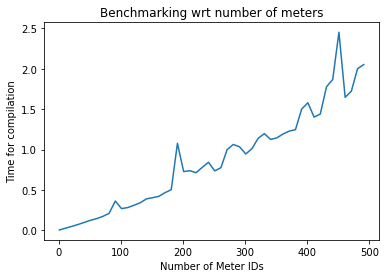

In [5]:
#Part 4 #Since the problem statement doesn't suggest inputting rates table, an assumption of constant rate is considered 
def part4(fc,ml,rate):
    fc = fc.set_index('Meter ID')
    ml = ml.set_index('Meter ID')
    
    tcpm = list()
    tc = list()
    mid = list()    

    for i,row in ml.iterrows():
    
        fcreq = fc.loc[i]
        fcreq = fcreq.reset_index()
        
        tcpm.append(sum(pd.Series(fcreq['kWh'])*rate/100))
        tc.append(sum(fcreq['kWh']))
        mid.append(i)
        
    tcpm = [round(num, 2) for num in tcpm] #Rounding up for 2 decimal spots
    tc = [round(num, 2) for num in tc]
    
    part4 = pd.DataFrame(list(zip(mid,tc,tcpm)), columns =['Meter ID', 'Total Estimated Consumption (kWh)','Total Cost (£)'])

    return part4

#Benchmarking
time1=list()
numids = np.arange(1,500,10) #Complexity wrt number of meters
for i in numids: 
    mlnew = part2(rates,i)
    fcnew = part3(mlnew['Meter ID'],1,1,2020,31,12,2022)
    start_time = timeit.default_timer()
    part4(fcnew,mlnew,0.0287)
    time1.append(timeit.default_timer() - start_time)
    
nummetcom = pd.DataFrame(list(zip(numids,time1)), columns =['Number of Meter IDs', 'Time for compilation'])

plt.plot(numids,time1)
plt.xlabel('Number of Meter IDs')
plt.ylabel('Time for compilation')
plt.title('Benchmarking wrt number of meters')

Text(0.5, 1.0, 'Benchmarking wrt period lengh')

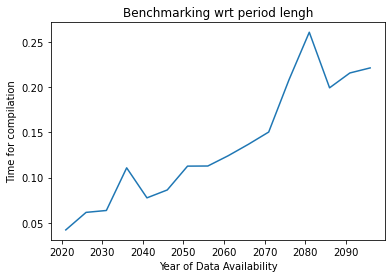

In [6]:
time2=list()
timids = np.arange(2021,2100,5) #Complexity wrt increasing time
for i in timids: 
    mlnew = part2(rates,10)
    fcnew = part3(mlnew['Meter ID'],1,1,2020,31,12,i)
    start_time = timeit.default_timer()
    part4(fcnew,mlnew,0.0287)
    time2.append(timeit.default_timer() - start_time)
    
timmetcom = pd.DataFrame(list(zip(timids,time2)), columns =['Number of Meter IDs', 'Time for compilation'])

plt.plot(timids,time2)
plt.xlabel('Year of Data Availability')
plt.ylabel('Time for compilation')
plt.title('Benchmarking wrt period lengh')

#Part 5

As can be seen from the graphs from part 4, the time for compilation of the function grows fairly linearly with respect to number of meter ids. Also, th time for compilation of the function grows linearly with respect to the amount of forecasted data available. The process of calculation is fairly simple. Hence, it is difficult to find significant improvements. However, instead of using the entire data set at the same time, splitting it into parts as per the dates at which the rates change, helps keep the time complexity to minimum (The difference between part 1 and part 4). This would also be incredibly helpful as the size of data sets increase.